# EigenTorch Examples

In [1]:
import spdnn
import torch
import eigenfunctions as eF
import eigenoptim as eOptim
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal.windows import dpss

In [44]:
## Generate Example features
s1 = 8
s2 = 6
Xdat = torch.rand(s1, 20)
Xm = Xdat.mean(1).view(-1, 1)
X = (Xdat - Xm) @ (Xdat - Xm).t()
tgt= 5.0
Wdat = torch.rand(s1, s1)
W_init = dpss(s1, 2.0, Kmax=s2)
W_init = torch.from_numpy(np.flip(W_init.astype(np.float32), axis=0).copy())
e, v = torch.eig(Wdat, eigenvectors=True)
Wdat = v[:s2]
W = spdnn.StiefelParameter(Wdat.clone().detach().requires_grad_(True))

## BiMap and Optimization Example
___Demonstrate that output features are SPD and that weights remain semi-orthogonal after update.  Check for convergence with setting a target output matrix norm (frobenius)___

Text(0, 0.5, 'Loss')

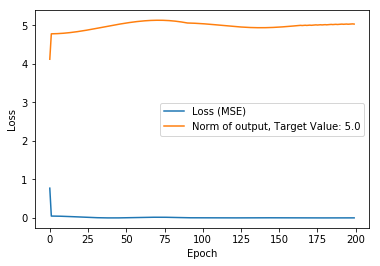

In [45]:
optim = eOptim.StiefelOpt([W], lr=0.001)
bimap_func = eF.BiMap.apply
spd_arr = []
wne_arr = []
wor_arr = []
loss_arr = []
norm_arr = []

def check_spd(mat1):
    """
    check for spd by checking for positive norms of submatrices X[0:idx, 0:idx] where 0 < idx <= rank(X)
    Also check for symmetry.
    """
    result = True
    for idx in range(1, mat1.shape[0]):
        norm_val = mat1[:idx, :idx].norm()
        if norm_val <= 0.0:
            result = False
        for midx in range(idx, mat1.shape[0]):
            if (mat1[idx, midx] - mat1[midx, idx]) > 1e-3:
                result = False
    return result

def check_sortho(mat1):
    """
    Check to make sure matrix is semi-orthogonal 
    """
    tmat = mat1 @ mat1.t()
    idxs = torch.ones(s2).diag() == 0
    valid = (tmat[idxs] < 1e-6).all()
    if not valid:
        print(tmat)
    return valid

# Loop through weight updates and check parameters and outputs
for epoch in range(200):
    W_old = W.clone().detach()
    # BiMap output and loss
    output = bimap_func(X, W)
    output = eF.ReEig(output, 1e-4)
    #loss = torch.mean((output - tgt) **2)
    nval = output.norm()
    norm_arr.append(nval)
    loss = (nval - tgt)**2
    loss_arr.append(loss.item())
    loss.backward()
    optim.step()
    # Update Arrays for checking properties
    spd_arr.append(check_spd(output))
    wne_arr.append((W == W_old).sum() == 0)
    wor_arr.append(check_sortho(W))

# Ensure Parameters actually updated
assert(torch.tensor(wne_arr).all())
# Ensure updated Parameters are semi-orthogonal
assert(torch.tensor(wor_arr).all())
# Ensure Output is SPD
assert(torch.tensor(spd_arr).all())
# Plot Loss over time
plt.plot(loss_arr)
plt.plot(norm_arr)
plt.legend(['Loss (MSE)', 'Norm of output, Target Value: {:.1f}'.format(tgt)])
plt.xlabel("Epoch")
plt.ylabel("Loss")

    
    

